# Clustering de usuarios 



In [2]:
# importamos las librerías usuales de python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

import seaborn as sns
import plotly.express as px

#Importing tqdm function of tqdm module 
from tqdm import tqdm
from time import sleep 

# importamos los algoritmos de clusterizacion a utilizar en esta notebook
from sklearn.cluster import KMeans                    # K-means

# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing  #para normalizacion

#Para agilizar el proceso de clusterización en el dataset vamos identificar las componentes principales
# Clase para realizar componentes principales
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#coeficiente de silhouette
from sklearn.metrics import silhouette_samples # importamos la clase que computa el coeficiente de silhouette para cada sample
from sklearn.metrics import silhouette_score # importamos la clase con la que se calcula el puntaje de silhouette (que es el promedio de los coeficientes de silhouette para cada sample)

In [155]:
# Crear estos directorios en el directorio actual
DIR_CLUSTERING_RESULTS='./kmeans-clustering-results/'
DIR_CLUSTERING_PLOTS='./kmeans-clustering-plots/'

##### Funciones Auxiliares

In [151]:
"""
Dado un dataframe, chequea valores nan
Si existen nans, devuelve la columna y la cantidad de nans
"""
def Chequearnan(df):
    for col in df.columns:
        nans = df[col].isna().sum()
        if nans > 0:
            print(col, nans)
            
"""
Dado un rango de clusters a probar
calcula los coeficientes de silhouette y el puntaje
"""
def generar_coeficientes_y_score(df,rango_clusters,n_state):
    #Creamos una lista para guardar de los coeficientes de silhouette para cada valor de k 
    silhouette_coefficients = []
    score = []
    # Se necesita tener al menos 2 clusters y a los sumo N-1 (con N el numero de muestras) para obtener coeficientes de Silohuette
    for k in tqdm(rango_clusters):
      #Inicializo kmeans con k clusters
      kkkmeans = KMeans(n_clusters=k, init='k-means++', random_state=n_state)
      #Aplico algoritmo Kmeans sobre los datos normalizados
      kkkmeans.fit(df)
      score = silhouette_score(df, kkkmeans.labels_)
      silhouette_coefficients.append(score)
    features = list(df.columns)
    (pd.DataFrame(silhouette_coefficients)).to_csv(DIR_CLUSTERING_RESULTS+'coeff-'+str(len(features))+'-features-'+str(features)+'-random-state-'+str(n_state))
    return silhouette_coefficients, score

"""
Dado los coeficientes de silhouette, devuelve el cluster donde se alcanza 
 el maximo score y el score maximo correspondiente
"""
def ret_cluster_y_max_score(silhouette_coefficients, rango_clusters):
    max_score = max(silhouette_coefficients)
    position = [k for k in range(0,len(silhouette_coefficients)) 
               if silhouette_coefficients[k] == max_score][0]
    cluster = list(rango_clusters)[position]
    return cluster, max_score


"""
Dado un dataframe, un rango de clusters, y coeficientes de silhouette
ploteamos para encontrar un maximo local.
"""

def plot_silhouette(df, rango_clusters, silhouette_coefficients, x_max, y_max, n_state):
    fig, ax = plt.subplots(figsize = (10, 7))
    # estas lineas son el grafico de SSEvsK
    ax.scatter(np.arange(2,16,1), silhouette_coefficients)            
    ax.set_xticks(np.arange(2,16,1))
    ax.set_title('Puntaje de Silhouette en función de cantidad de clusters',fontsize=20)
    ax.set_xlabel("Número de clusters k",fontsize=12)
    ax.set_ylabel("Promedio coeficientes de Silhouette",fontsize=12)
    #x = 5
    #y = silhouette_coefficients[3]
    ax.annotate('Máximo local', (x_max+0.2, y_max+0.002), fontsize=12)
    ax.axvline(x=x_max,linestyle='dashdot', color='red')
    ax.axhline(y=y_max,linestyle='dashdot',color='grey')
    features =list(df.columns)
    plt.savefig(DIR_CLUSTERING_PLOTS+'score-silhouette-'+str(len(features))+'-features-'+str(features)+'-random-state-'+str(n_state)+'.png')

"""
Dado un df normalizado y la cantidad de clusters donde alcance el maximo local con silhouette
(y el random state correspondiente al KMeans), esta funcion devuelve el vector de etiquetas
"""
def labels_kmeans(df, clusters, n_state):
    # genero el objeto KMeans con la cantidad de clusters donde alcance el maximo y el random_state correspondiente
    kmeans = KMeans(n_clusters=clusters, init='k-means++',random_state=n_state)
    #recordar que df debe estar normalizado
    return kmeans.fit_predict(df)


def plot_clusters(df, clusters):
    #Getting unique labels
    plt.figure(figsize=(9, 8))
    #plotting the results:
    for i in clusters:
        plt.scatter(np.log(df[df.cluster == i][0]) , np.log(df[df.cluster == i][1]), label = 'cluster'+str(i), alpha=0.3, s=5)
    plt.title('Primeras dos componentes de PCA after clustering')
    plt.xlabel('Primera componente')
    plt.ylabel('Segunda componente')
    plt.legend()
    plt.savefig(DIR_CLUSTERING_PLOTS+'plot_clusters_max_local_'+str(len(clusters))+'.png')


## Levanto la data

Para poder clusterizar quiero una matriz de n usuarios x m features numericas

In [5]:
df_users = pd.read_csv('./data/df_users.csv',index_col=[0])

In [8]:
df_users.shape, df_users.userId.nunique(), Chequearnan(df_users)

((142246, 16), 142246, None)

In [30]:
df_users.head(1)

,userId,director_fav,film_decade_std,rating_std,rating_mean,film_decade_median,decade_fav,year_std,movies_count,director_fav_per,year_fav,decade_fav_per,rating_median,year_median,decade_fav_count,director_fav_count
0,1,['Ingmar Bergman'],20.475203,1.004235,3.814286,1990.0,2000,19.971636,70,0.157143,2004.0,0.128571,4.0,1994.0,9,11


# Selecciono features y Normalizacion
['film_decade_std',
  'decade_fav',
  'decade_fav_per',
  'rating_std',
  'film_decade_median',
  'year_median',
  'rating_mean',
  'director_fav_per',
  'movies_count']

In [17]:
features_to_normalize =[  'film_decade_std',
                          'decade_fav',
                          'decade_fav_per',
                          'rating_std',
                          'film_decade_median',
                          'year_median',
                          'rating_mean',
                          'director_fav_per',
                          'movies_count']
features_to_normalize , len(features_to_normalize)

(['film_decade_std',
  'decade_fav',
  'decade_fav_per',
  'rating_std',
  'film_decade_median',
  'year_median',
  'rating_mean',
  'director_fav_per',
  'movies_count'],
 9)

In [25]:
df_normalizado = pd.DataFrame(preprocessing.normalize(df_users[features_to_normalize], axis=0))
df_normalizado.columns = features_to_normalize

In [28]:
df_normalizado.shape, Chequearnan(df_normalizado)

((142246, 9), None)

In [29]:
df_normalizado.head(1)

,film_decade_std,decade_fav,decade_fav_per,rating_std,film_decade_median,year_median,rating_mean,director_fav_per,movies_count
0,0.004742,0.00266,0.001175,0.002753,0.002649,0.002648,0.002703,0.002829,0.001724


# Clustering con KMeans

#### Criterio de Silhoutte

In [43]:
sil_coeff, score = generar_coeficientes_y_score(df_normalizado,np.arange(2,16,1),1)

100%|██████████████████████████████████████████| 14/14 [54:09<00:00, 232.08s/it]


In [87]:
k_max , max_score = ret_cluster_y_max_score(sil_coeff, np.arange(2,16,1))

In [89]:
#resultados con random_state = 1
# guardamos el resultado de los coeficientes con la funcion generar_coeficientes_y_score, indicando el random_state
print('\n features normalizadas=',features_to_normalize)
print('\n Silhouette coefficients=',sil_coeff)
print('\n Cluster donde se alcanza el maximo local =',k_max)
print('\n maximo score de silhouette obtenido = ', max_score)
print('\n score obtenido =',score)


 features normalizadas= ['film_decade_std', 'decade_fav', 'decade_fav_per', 'rating_std', 'film_decade_median', 'year_median', 'rating_mean', 'director_fav_per', 'movies_count']

 Silhouette coefficients= [0.28037485516390037, 0.288270239019996, 0.33079935596029725, 0.3424621614293421, 0.2620105519036658, 0.2688292277952895, 0.26118675398106717, 0.25982372145210814, 0.24574127452803227, 0.23996796442238177, 0.2385070582278502, 0.23544973507380157, 0.21822313595272586, 0.21723034199194594]

 Cluster donde se alcanza el maximo local = 5

 maximo score de silhouette obtenido =  0.3424621614293421

 score obtenido = 0.21723034199194594


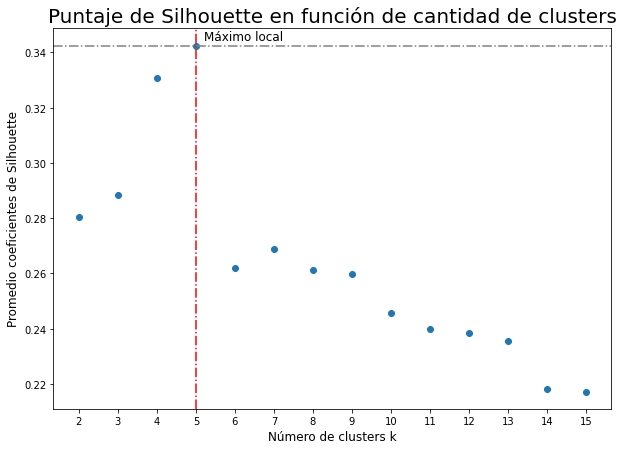

In [84]:
#guardamos este plot al correr la funcion
plot_silhouette(df_normalizado ,np.arange(2,16,1), sil_coeff, k_max, max_score, 1)

#### Resultado: KMeans con random_state=1 considerando 9 features : maximo local 5 

 features normalizadas= ['film_decade_std', 'decade_fav', 'decade_fav_per', 'rating_std', 'film_decade_median', 'year_median', 'rating_mean', 'director_fav_per', 'movies_count']

 Silhouette coefficients= [0.28037485516390037, 0.288270239019996, 0.33079935596029725, 0.3424621614293421, 0.2620105519036658, 0.2688292277952895, 0.26118675398106717, 0.25982372145210814, 0.24574127452803227, 0.23996796442238177, 0.2385070582278502, 0.23544973507380157, 0.21822313595272586, 0.21723034199194594]

 Cluster donde se alcanza el maximo local = 5

 maximo score de silhouette obtenido =  0.3424621614293421

 score obtenido = 0.21723034199194594

In [91]:
df_normalizado.head(3)

,film_decade_std,decade_fav,decade_fav_per,rating_std,film_decade_median,year_median,rating_mean,director_fav_per,movies_count
0,0.004742,0.002660,0.001175,0.002753,0.002649,0.002648,0.002703,0.002829,0.001724
1,0.002686,0.002647,0.000646,0.003996,0.002649,0.002652,0.002573,0.000880,0.004531
2,0.002978,0.002673,0.001284,0.003062,0.002662,0.002668,0.002394,0.001041,0.005959


In [92]:
pred_km = labels_kmeans(df_normalizado, 5, 1)

In [101]:
len(pred_km), pred_km[:10]

(142246, array([4, 2, 2, 4, 1, 0, 2, 2, 4, 4], dtype=int32))

In [123]:
#En un dataframe le asigno a cada usuario el cluster correspondiente
userid_cluster = pd.DataFrame({'userId':df_users.userId,'cluster':pred_km}).reset_index(drop=True)

#Agrego las columnas userId y cluster al dataframe con las features normalizadas
df_normalizado['userId'] = userid_cluster.userId
df_normalizado['cluster'] = userid_cluster.cluster

#Agrego el cluster al dataframe de usuarios inicial, que contiene todas las features para los usuarios
df_users = df_users.merge(userid_cluster, on='userId')

In [124]:
df_users.to_csv(DIR_CLUSTERING_RESULTS+'df_users_kmeans_9_features_max_local_5.csv')
df_normalizado.to_csv(DIR_CLUSTERING_RESULTS+'df_normalizado_kmeans_9_features_max_local_5.csv')

## Clustering Plot usando PCA

In [126]:
#primero uso PCA con dos componentes para poder plotear
# Creación del modelo de PCA con 2 componentes
pca = PCA(n_components = 2,random_state=0)

# Ajuste y transformación de los datos
pca.fit(df_normalizado[features_to_normalize])
data_pca = pca.transform(df_normalizado[features_to_normalize])

In [128]:
data_pca = pd.DataFrame(data_pca)
# Agrego el cluster para poder plotear
data_pca['cluster'] =  userid_cluster.cluster

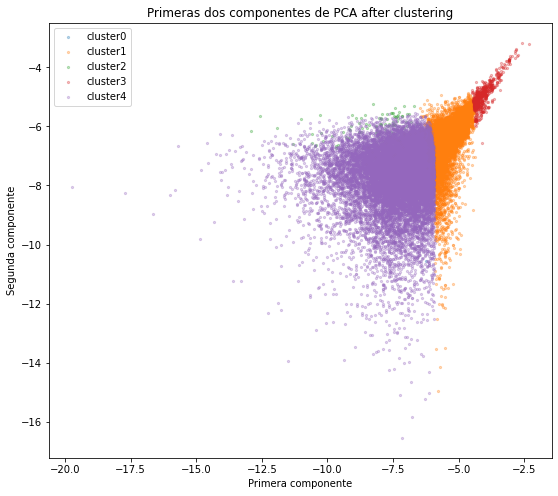

In [156]:
#guardamos este plot al correr la funcion
plot_clusters(data_pca, list(data_pca.cluster.sort_values().unique()))